In [1]:
import utils
import pandas as pd
import numpy as np

c:\Users\antonio\anaconda3\envs\causal_ds_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

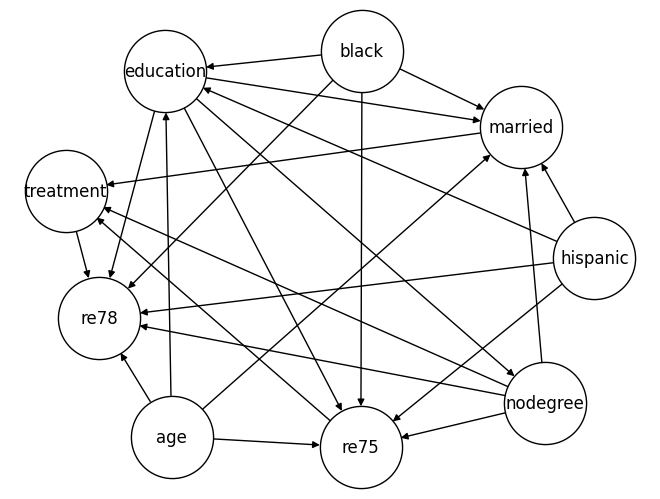

In [2]:
lalonde_original, nswre_df, cps_control, psid_control, cps2_control, cps3_control, psid2_control, psid3_control = utils.load_data()
nswre_cps, nswre_cps2, nswre_cps3, nswre_psid, nswre_psid2, nswre_psid3 = utils.load_combinations(nswre_df, cps_control, cps2_control, cps3_control,  psid_control, psid2_control, psid3_control)

graph = utils.extract_CD_graph("Forced_Graph") #Loads the graph from json
utils.draw_graph(graph) #plots the graph
combinations_dict = {"nswre_experiment": nswre_df, 
                     "nswre_cps": nswre_cps, 
                     "nswre_cps2": nswre_cps2, 
                     "nswre_cps3": nswre_cps3, 
                     "nswre_psid": nswre_psid, 
                     "nswre_psid2": nswre_psid2, 
                     "nswre_psid3": nswre_psid3}

## Baseline Check

In [6]:
utils.baseline_1999(combinations_dict, methods=["backdoor.linear_regression"], refuter_list=["data_subset_refuter", "placebo_treatment_refuter"])

,treatment,outcome,backdoor.linear_regression,data_subset_refuterbackdoor.linear_regression,placebo_treatment_refuterbackdoor.linear_regression
nswre_experiment,treatment,re78,1794.342404,1827.765879,7.938059
nswre_cps,treatment,re78,-8497.516143,8542.954254,7.596470
nswre_cps2,treatment,re78,-3821.967430,3824.777930,78.503836
nswre_cps3,treatment,re78,-635.026212,663.204107,37.160323
nswre_psid,treatment,re78,-15204.777468,15192.502443,17.246024
nswre_psid2,treatment,re78,-3646.806447,3671.391507,186.063178
nswre_psid3,treatment,re78,1069.849904,1113.591864,58.831143


In [7]:
backdoor_group, frontdoor_group, iv_group = utils.indentify_effects(graph, nswre_df) #, pairs=[("treatment", "re78")]

In [14]:
backdoor_group

,treatment,outcome,backdoor
18,treatment,re78,"[nodegree, re75, married]"
19,married,treatment,"[nodegree, re75]"
20,married,re78,"[nodegree, education, age, black, hispanic]"
21,education,treatment,"[age, black, hispanic]"
22,education,married,"[age, black, hispanic]"
24,education,re75,"[age, black, hispanic]"
25,education,re78,"[age, black, hispanic]"
26,nodegree,treatment,[education]
27,nodegree,married,[education]
28,nodegree,re75,[education]


In [9]:
frontdoor_group

,treatment,outcome,frontdoor
0,black,treatment,"[education, married, re75, nodegree]"
3,black,nodegree,[education]
6,hispanic,treatment,"[education, married, re75, nodegree]"
9,hispanic,nodegree,[education]
12,age,treatment,"[education, married, re75, nodegree]"
15,age,nodegree,[education]


In [10]:
iv_group

,treatment,outcome,instrumental_variables
23,education,nodegree,"[age, hispanic, black]"


In [18]:
backdoor_list = ["backdoor.linear_regression", 
                 #"backdoor.distance_matching",     # need to specify a distance metric
                 #"backdoor.propensity_score_stratification", # not enough data for some combinations 
                 #"backdoor.propensity_score_matching", # takes a lot of time 
                 "backdoor.propensity_score_weighting"]

backdoor_results = None
for i, row in backdoor_group.iterrows():
    print(row["treatment"], row["outcome"])
    # We cannot use continuous treatment for propensity score
    if row["treatment"] not in ["re74", "re75", "re78", "education"]:
        df = utils.causal_effect(combinations_dict, 
                    graph, 
                    methods=backdoor_list, 
                    refuter_list = ["data_subset_refuter", "placebo_treatment_refuter"], 
                    treatment= row["treatment"],
                    outcome= row["outcome"])
        if backdoor_results is None:
            backdoor_results = pd.DataFrame(columns=list(df.columns))

    backdoor_results = pd.concat([backdoor_results, df], axis=0)
  


treatment re78
married treatment
married re78
education treatment
education married
education re75
education re78
nodegree treatment
nodegree married
nodegree re75
nodegree re78
re75 treatment
re75 re78


In [19]:
backdoor_results

,treatment,outcome,backdoor.linear_regression,data_subset_refuterbackdoor.linear_regression,placebo_treatment_refuterbackdoor.linear_regression,backdoor.propensity_score_weighting,data_subset_refuterbackdoor.propensity_score_weighting,placebo_treatment_refuterbackdoor.propensity_score_weighting
nswre_experiment,treatment,re78,1564.964653,1553.954025,6.276414,1563.329509,1590.838638,270.749679
nswre_cps,treatment,re78,71.401804,71.067760,8.257235,-8193.897814,8202.277597,284.975945
nswre_cps2,treatment,re78,-89.647943,106.218992,23.969040,-3276.954689,3300.501790,1720.250705
nswre_cps3,treatment,re78,488.942787,475.936353,24.806525,378.536121,345.999806,1365.037760
nswre_psid,treatment,re78,880.114443,884.519529,4.833631,-13065.420938,13067.789007,4280.226099
...,...,...,...,...,...,...,...,...
nswre_cps2,nodegree,re78,-2207.181223,2198.441049,4.248702,-1431.454741,1426.733083,1730.909798
nswre_cps3,nodegree,re78,-886.077317,817.378472,12.944576,-1368.090694,1367.995961,1294.673267
nswre_psid,nodegree,re78,-1264.149806,1262.374176,37.055810,-6000.451722,5975.389743,4348.678623
nswre_psid2,nodegree,re78,-2606.284300,2627.326615,8.240389,-264.511964,376.666054,7842.451114


In [22]:
# frontdoor.two_stage_regression
#frontdoor_list = ["frontdoor.two_stage_regression"] # Need on only one var in the conditioning set
frontdoor_list = ["frontdoor.linear_regression", 
                 #"backdoor.distance_matching",     # need to specify a distance metric
                 #"backdoor.propensity_score_stratification", # not enough data for some combinations 
                 #"backdoor.propensity_score_matching", # takes a lot of time 
                 "frontdoor.propensity_score_weighting"]

# Couldnt make it work

frontdoor_results = None
for i, row in frontdoor_group.iterrows():
    # We cannot use continuous treatment for propensity score
    if row["treatment"] not in ["re74", "re75", "re78", "education"]:
        df = utils.causal_effect(combinations_dict, 
                    graph, 
                    methods=frontdoor_list, 
                    refuter_list = ["bootstrap_refuter", "data_subset_refuter", "placebo_treatment_refuter"], 
                    treatment= row["treatment"],
                    outcome= row["outcome"])
        if frontdoor_results is None:
            frontdoor_results = pd.DataFrame(columns=list(df.columns))

    frontdoor_results = pd.concat([frontdoor_results, df], axis=0)

In [ ]:
frontdoor_results

In [23]:
iv_list = ["iv.instrumental_variable", "iv.regression_discontinuity"]

iv_results = None
for i, row in iv_group.iterrows():
    # We cannot use continuous treatment for propensity score
    if row["treatment"] not in ["re74", "re75", "re78", "education"]:
        df = utils.causal_effect(combinations_dict, 
                    graph, 
                    methods=["backdoor.propensity_score_weighting"], 
                    refuter_list = ["bootstrap_refuter", "data_subset_refuter", "placebo_treatment_refuter"], 
                    treatment= row["treatment"],
                    outcome= row["outcome"])
        if iv_results is None:
            iv_results = pd.DataFrame(columns=list(df.columns))

    iv_results = pd.concat([iv_results, df], axis=0)


In [24]:
iv_results

,treatment,outcome,backdoor.linear_regression,data_subset_refuterbackdoor.linear_regression,placebo_treatment_refuterbackdoor.linear_regression,backdoor.propensity_score_weighting,data_subset_refuterbackdoor.propensity_score_weighting,placebo_treatment_refuterbackdoor.propensity_score_weighting
nswre_experiment,nodegree,re78,-867.569874,845.951286,49.872439,-1802.627940,1771.111644,259.642039
nswre_cps,nodegree,re78,-2597.408790,2579.201130,2.833990,-2694.583283,2687.829835,275.179681
nswre_cps2,nodegree,re78,-2207.181223,2198.441049,4.248702,-1431.454741,1426.733083,1730.909798
nswre_cps3,nodegree,re78,-886.077317,817.378472,12.944576,-1368.090694,1367.995961,1294.673267
nswre_psid,nodegree,re78,-1264.149806,1262.374176,37.055810,-6000.451722,5975.389743,4348.678623
nswre_psid2,nodegree,re78,-2606.284300,2627.326615,8.240389,-264.511964,376.666054,7842.451114
nswre_psid3,nodegree,re78,-186.589556,98.179205,52.679177,-2467.654036,2392.104380,884.313046
